# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека, имея набор фотографий людей с указанием возраста.

**План работы:**
1. Провести исследовательский анализ набора фотографий.
1. Подготовить данные к обучению.
1. Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных
Подключим необходимые библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=0) 

Found 7591 validated image filenames.


Отобразим размер выборки с помощью `shape`:

In [3]:
print("Размер выборки:", data.shape)

Размер выборки: (7591, 2)


In [4]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Построим график распределения возраста в выборке:

plt.figure(figsize=(6,4))
plt.hist(x)
plt.xlabel("Months")
plt.ylabel("Donated")
plt.show()

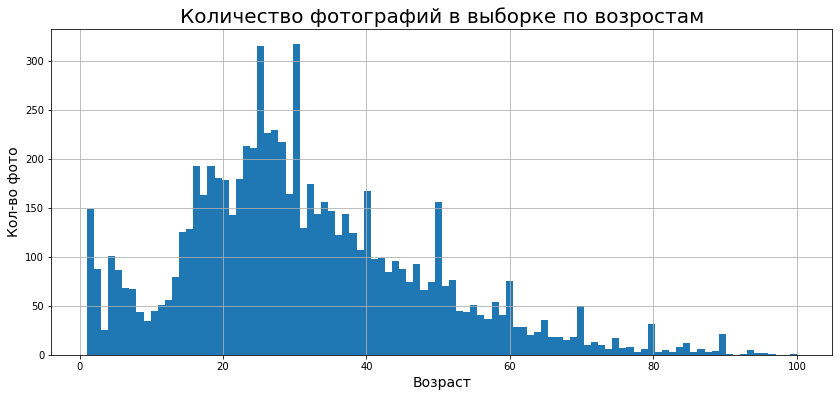

In [13]:
plt.figure(figsize=(14, 6))
plt.hist(data['real_age'], bins=100)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Кол-во фото', fontsize=14)
plt.title('Количество фотографий в выборке по возростам', fontsize=20)
plt.grid()
plt.show();

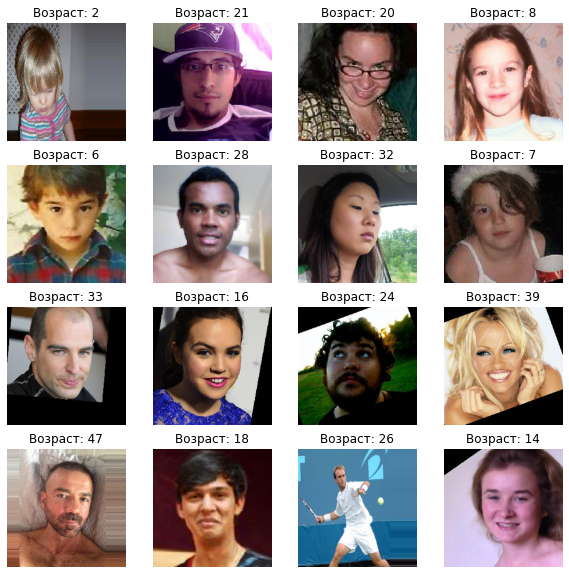

In [24]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.axis('off')
    plt.title('Возраст: {}'.format(target[i]))

По результатам ииследовательского анализа данных можно сделать следующие выводы:
- Выборка содержит 7591 фотографий;
- В выборке содержатся фотографии людей от возрастом 1 до 100 лет;
- Средний возраст в выборке - 31 год;
- Дополнительная обработка фотографий (поворот по вертикали или горизонтали) не нужна;
- В выборке представлены как цветные, так и чернобелые фотографии.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                      directory=path+'/final_files',    
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      subset='training',  
                                                      seed = 0)
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                         directory=path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',     
                                                         seed = 0)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 110s - loss: 294.5100 - mae: 12.5205 - val_loss: 698.6328 - val_mae: 21.4812
Epoch 2/10
178/178 - 89s - loss: 118.1622 - mae: 8.1958 - val_loss: 481.2846 - val_mae: 16.6792
Epoch 3/10
178/178 - 88s - loss: 100.8308 - mae: 7.5871 - val_loss: 314.4513 - val_mae: 13.1839
Epoch 4/10
178/178 - 88s - loss: 84.3772 - mae: 6.9776 - val_loss: 125.3787 - val_mae: 8.5667
Epoch 5/10
178/178 - 88s - loss: 72.5015 - mae: 6.5023 - val_loss: 96.3381 - val_mae: 7.3782
Epoch 6/10
178/178 - 88s - loss: 67.4346 - mae: 6.2673 - val_loss: 80.5660 - val_mae: 6.9621
Epoch 7/10
178/178 - 88s - loss: 61.1549 - mae: 5.9710 - val_loss: 127.3368 - val_mae: 8.4170
Epoch 8/10
178/178 - 88s - loss: 57.8611 - mae: 5.8449 - val_loss: 100.4298 - val_mae: 7.3453
Epoch 9/10
178/178 - 88s - loss: 51.3704 - mae: 5.4883 - val_loss: 76.0843 - val_mae: 6.4214
Epoch 10/10
178/178 - 88s - loss: 46.3594 - mae: 5.2377 - val_loss: 81.1847 - val_mae: 6.6691
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 81.1847 - mae: 6.6691
Test MAE: 6.6691
```

Полученная метрика MAE меньше 7, задача выполнена.

## Анализ обученной модели

Была обучена модель со следующими характеристиками:
- архитектура ResNet50;
- алгоритм адаптивной оптимизации Adam;
- частота обучения 0.0001;
- 10 эпох.

**Полученная в результате обучения метрика MAE меньше 7, задача выполнена.**

## Выводы


Первым этапом работы был исследовательский анализ данных, в результате которого выяснилось следующее:
- Выборка содержит 7591 фотографий;
- В выборке содержатся фотографии людей от возрастом 1 до 100 лет;
- Средний возраст в выборке - 31 год;
- Дополнительная обработка фотографий (поворот по вертикали или горизонтали) не нужна;
- В выборке представлены как цветные, так и чернобелые фотографии.

Далее была обучена модель со следующими характеристиками:
- архитектура ResNet50;
- алгоритм адаптивной оптимизации Adam;
- частота обучения 0.0001;
- 10 эпох.

И получена МАЕ, эквивалентная 6.6691.